In [29]:
# Standard Library Imports
import os                       # Operating system functions
import subprocess               # Subprocess management
import random                   # Random number generation
from tqdm import tqdm           # Progress bars
from pathlib import Path        # Path manipulation

# Data Manipulation and Visualization
import json                     # JSON data manipulation
import inspect                  # Inspection of live objects
import pandas as pd             # Data manipulation using DataFrames
import numpy as np              # Numerical operations
import matplotlib.pyplot as plt # Plotting
import seaborn as sns           # Styling plots

# Image Processing
from PIL import Image           # Python Imaging Library for image processing
import cv2                      # OpenCV library for computer vision

# Model Libraries
try:
  import timm                     # Used for pre-trained models such as EfficientNet, ViT
except ImportError:
  import subprocess
  subprocess.run(['pip', 'install', 'timm'])
  import timm

# PyTorch
import torch                    # PyTorch overall import
import torch.optim as optim     # Optimization of model parameters
import torch.nn as nn           # Specification of neural networks
from torch.utils.data import Dataset, DataLoader  # Data loading utilities
import torchvision.transforms as transforms      # Pre-processing data

In [2]:
# Check if Apple silicon mps device is available
if torch.backends.mps.is_available():
    print("Using Apple silicon mps device.")
# Check if Nvidia CUDA device is available
elif torch.cuda.is_available():
    print("Using Nvidia CUDA device.")
# If no GPU is available, use CPU
else:
    print("Using CPU.")

Using Nvidia CUDA device.


### Define Configuration. Change directory path accordingly!

In [32]:
class Config:
    try:
        # Mount Google Drive in Google Colab
        from google.colab import drive
        drive.mount('/content/gdrive/')
        
        # Set the working directory in Google Colab
        new_directory = '/content/gdrive/MyDrive/EE562 AI/EE 562 Final Project/tiny-imagenet'
        os.chdir(new_directory)
        IN_COLAB = True
    except ImportError:
        # If not in Google Colab, set flag accordingly
        IN_COLAB = False

    # Visualize Data flag
    _visualize_data = True

    # Reproducibility seed
    SEED = 42

    # Model Hyperparameters
    epochs = 30
    model_name = 'vit_base_patch16_224'  # Model choices: 'resnet_152', 'efficientnet_{b0, b1, ... , b7}', 'vit_base_patch16_224', 'vit_large_patch16_224'
    _in_channels = 3  # RGB images
    image_res = 64
    num_classes = 200
    use_pretrained_model = False
    _trained_weight_path = os.path.join('weights', 'best_vit_large_patch16_224_lr-1e-05_dropout-0.1_dataAug-True.pth')
    if use_pretrained_model:
        assert(Path(_trained_weight_path).is_file())
    batch_size = 128  # Change batch size to fit memory budget
    learning_rate = 1e-2  # Learning rate choices: 1e-3, 1e-4, 1e-5, 1e-6, 1e-7
    dropout_rate = 0.2  # Dropout rate choices: 0, 0.1, 0.2, 0.3, 0.4, 0.5
    attn_pos_drop_ratio = 10  # Apply dropout_rate * ratio to attention and position embedding layers
    l2_regularization_strength = 0  # L2 regularization strength choices: 0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7
    use_data_aug = True

    # Loss
    use_contrastive = False
    lambda_contrastive = 10  # Choices: 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7

    # Data Paths
    _data_path = 'data'
    dataset = 'tiny-imagenet-200'
    _ds_path = os.path.join(_data_path, dataset)
    _data_csv_path = os.path.join(_ds_path, 'tinyimagenet.csv')
    _data_pickle_path = os.path.join(_ds_path, 'tinyimagenet.pickle')

    # Saving Paths
    _result_dir = "results"
    _weight_dir = "weights"
    if not os.path.exists(_result_dir):
        os.makedirs(_result_dir)
    if not os.path.exists(_weight_dir):
        os.makedirs(_weight_dir)

    # File Names and Paths
    _model_fname = f"best_{model_name}_lr-{learning_rate}_dropout-{dropout_rate}_pretrained-{use_pretrained_model}_use_dataAug-{use_data_aug}_epochs-{epochs}"
    _save_result_path = os.path.join(_result_dir, _model_fname)
    _save_weight_path = os.path.join(_weight_dir, f'{_model_fname}.pth')
    _dict = {}

# Create an instance of the Config class
config = Config()

### Construct Data Frame

In [21]:
def load_DF_from_csv():
    """
    Loads or creates a DataFrame from a CSV file containing dataset information.

    Outputs:
    - Returns a pandas DataFrame containing the dataset information.
    """
    if os.path.exists(config._data_csv_path):
        print('Loading existing data csv file')
        # Load DataFrame from CSV file
        df = pd.read_csv(config._data_csv_path)
    else:
        print('Creating data csv file')
        # Specify the data path
        data_path = config._ds_path

        # Specify the words file name
        words_file_path = os.path.join(data_path, "words.txt")

        # Read data from the file
        with open(words_file_path, 'r') as file:
            words = file.read()

        # Split the data into lines
        lines = words.split('\n')

        # Construct the dictionary
        label2text = {}
        for line in lines:
            if line:
                key, value = line.split(maxsplit=1)
                label2text[key] = value

        # Print the resulting dictionary
        train_dir = os.path.join(data_path, 'train')
        val_dir = os.path.join(data_path, 'val')
        dirs = {'train': train_dir, 'val': val_dir}

        data_list = []
        img_tensors = []

        # Iterate over datasets and labels
        for ds, ds_path in dirs.items():
            for label in os.listdir(ds_path):
                label_dir = os.path.join(ds_path, label)
                if os.path.isdir(label_dir):
                    for image_path in os.listdir(label_dir):
                        if not image_path.split('.')[-1] == 'JPEG':
                            continue
                        image_path = os.path.join(label_dir, image_path)
                        data_list.append({
                            'image_path': image_path,
                            'set': ds,
                            'label': label,
                            'label-description': label2text[label]
                        })
        # Create DataFrame and save to CSV
        df = pd.DataFrame(data_list)
        df.to_csv(config._data_csv_path, index=False)
    return df

def load_DF_from_pickle():
    """
    Loads or creates a DataFrame from a pickle file containing dataset information with images.

    Outputs:
    - Returns a pandas DataFrame containing the dataset information with images.
    """
    if os.path.exists(config._data_pickle_path):
        print('Loading existing pickle file to dataframe')
        # Load DataFrame from pickle file
        df = pd.read_pickle(config._data_pickle_path)
    else:
        print('Creating pickle file')
        # Specify the data path
        data_path = config._ds_path

        # Specify the words file name
        words_file_path = os.path.join(data_path, "words.txt")

        # Read data from the file
        with open(words_file_path, 'r') as file:
            words = file.read()

        # Split the data into lines
        lines = words.split('\n')

        # Construct the dictionary
        label2text = {}
        for line in lines:
            if line:
                key, value = line.split(maxsplit=1)
                label2text[key] = value

        # Print the resulting dictionary
        train_dir = os.path.join(data_path, 'train')
        val_dir = os.path.join(data_path, 'val')
        dirs = {'train': train_dir, 'val': val_dir}

        data_list = []

        # Iterate over datasets and labels using tqdm for progress
        for ds, ds_path in tqdm(dirs.items(), desc='Processing datasets'):
            for label in os.listdir(ds_path):
                label_dir = os.path.join(ds_path, label)
                if os.path.isdir(label_dir):
                    for image_path in tqdm(os.listdir(label_dir), desc=f'Processing images in {label}'):
                        if not image_path.split('.')[-1] == 'JPEG':
                            continue
                        image_path = os.path.join(label_dir, image_path)
                        data_list.append({
                            'image_path': image_path,
                            'set': ds,
                            'label': label,
                            'label-description': label2text[label],
                            'image_tensor': torch.from_numpy(cv2.imread(image_path))
                        })
        # Create DataFrame and save to pickle
        df = pd.DataFrame(data_list)
        df.to_pickle(config._data_pickle_path)
    return df

# Load DataFrame from pickle if in Colab, otherwise load from CSV
df = load_DF_from_pickle() if config.IN_COLAB else load_DF_from_csv()
df.sample(n=5).head()

Loading existing data csv file


,image_path,set,label,label-description
35341,data\tiny-imagenet-200\train\n02814533\n028145...,train,n02814533,"beach wagon, station wagon, wagon, estate car,..."
32691,data\tiny-imagenet-200\train\n02791270\n027912...,train,n02791270,barbershop
87896,data\tiny-imagenet-200\train\n04597913\n045979...,train,n04597913,wooden spoon
14198,data\tiny-imagenet-200\train\n02106662\n021066...,train,n02106662,"German shepherd, German shepherd dog, German p..."
12478,data\tiny-imagenet-200\train\n02085620\n020856...,train,n02085620,Chihuahua


### Investigate Dataset

Count of training images: 100000
Count of validation images: 10000
Total number of images: 110000
Train test split ratio: 0.9 : 0.1
num_unique_labels = 200


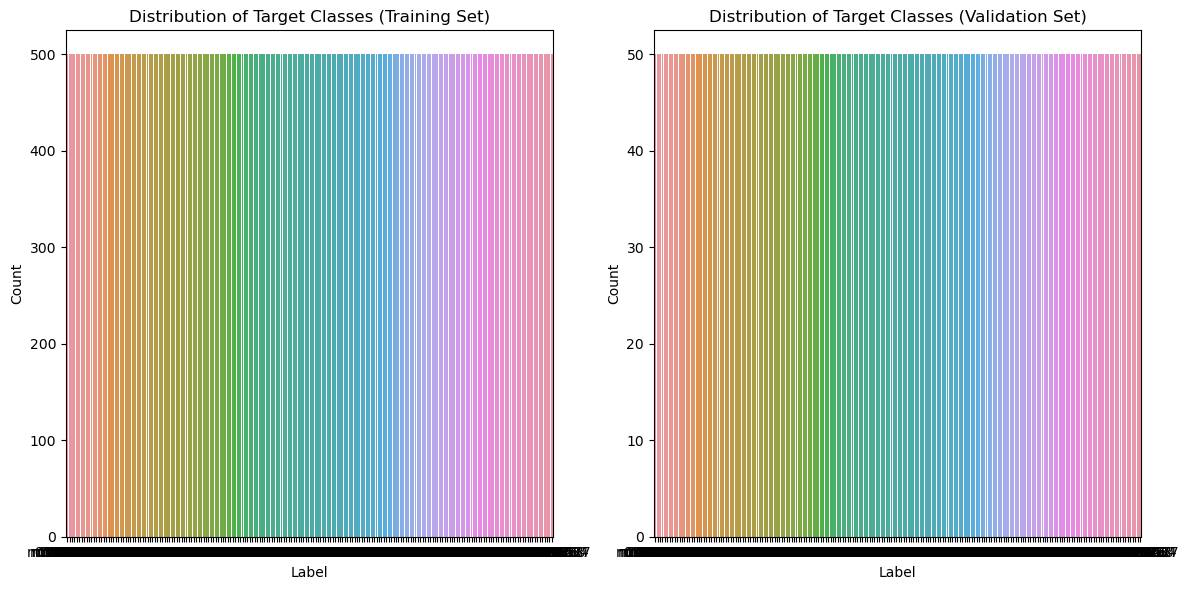

Class imbalance ratio: 1.0


In [22]:
def visualize_ds(df):
    """
    Visualizes basic statistics and the distribution of target classes in the dataset.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the dataset information.

    Outputs:
    - Prints basic statistics about the dataset, including counts of training and validation images,
      total number of images, train-test split ratio, and number of unique labels.
    - Displays plots showing the distribution of target classes in the training and validation sets.
    - Prints the class imbalance ratio.
    """
    train_count = df['set'].value_counts().get('train', 0)
    val_count = df['set'].value_counts().get('val', 0)
    num_unique_labels = df['label'].nunique()
    unique_labels = df['label'].unique()
    label_counts = df['label'].value_counts()
    
    # Get the counts for the least and most common labels
    least_common_count = label_counts.min()
    most_common_count = label_counts.max()
    imb_ratio = least_common_count / most_common_count
    
    # Print dataset statistics
    print("Count of training images:", train_count)
    print("Count of validation images:", val_count)
    print(f"Total number of images: {train_count + val_count}")
    print(f"Train test split ratio: {train_count/(train_count + val_count):.1f} : {val_count/(train_count + val_count):.1f}")
    print(f"{num_unique_labels = }")

    # Plot the distribution of the target classes for both training and validation sets
    plt.figure(figsize=(12, 6))

    # Training set
    plt.subplot(1, 2, 1)
    sns.countplot(data=df[df['set'] == 'train'], x='label', order=df['label'].value_counts().index)
    plt.title('Distribution of Target Classes (Training Set)')
    plt.xlabel('Label')
    plt.ylabel('Count')

    # Validation set
    plt.subplot(1, 2, 2)
    sns.countplot(data=df[df['set'] == 'val'], x='label', order=df['label'].value_counts().index)
    plt.title('Distribution of Target Classes (Validation Set)')
    plt.xlabel('Label')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

    print(f"Class imbalance ratio: {imb_ratio}")

# Visualize the dataset if the visualization flag is True
if config._visualize_data:
    visualize_ds(df)

### Data Visualization

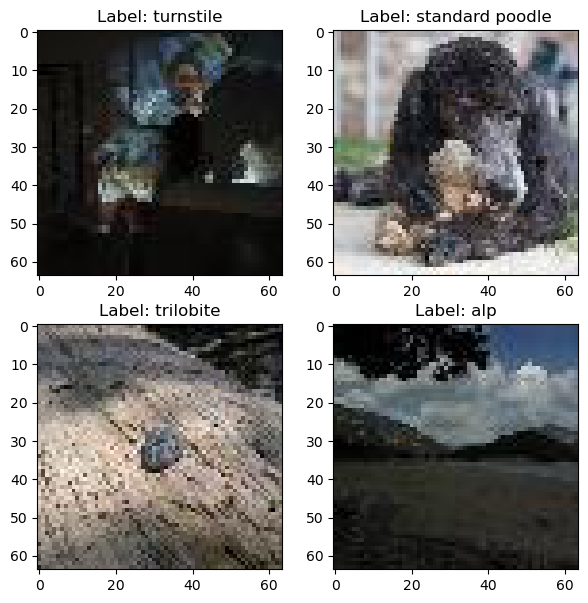

In [23]:
if config._visualize_data:
    # Set a seed for reproducibility
    random.seed(config.SEED)
    
    # Randomly sample 4 indices from the DataFrame
    random_indices = random.sample(range(len(df)), 4)
    
    # Plot the images with increased spacing
    plt.figure(figsize=(7, 7))

    # Iterate over the randomly sampled indices
    for i, index in enumerate(random_indices, 1):
        plt.subplot(2, 2, i)
        # Display images based on the environment (Colab or local)
        if config.IN_COLAB:
            plt.imshow(df['image_ndarray'].iloc[index])
        else:
            plt.imshow(plt.imread(df['image_path'].iloc[index]))
        plt.title(f"Label: {df['label-description'].iloc[index]}")

    plt.show()

### Perform one-hot encoding


In [24]:
# Perform one-hot encoding on the 'label' column
df_one_hot = pd.get_dummies(df["label"], prefix="label").astype(int)

# Extract columns from the original DataFrame excluding 'label'
exclude_columns = ['label']
additional_columns = df[[col for col in df.columns if col not in exclude_columns]]

# Concatenate the original DataFrame with the one-hot encoded labels
df_combined = pd.concat([df_one_hot, additional_columns], axis=1)

### Create a Pytorch Data Loading Pipeline

In [25]:
# Custom dataset class for loading images and corresponding labels
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        """
        Args:
            image_paths (list): List of file paths to the images.
            labels (list): List of corresponding labels.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
            int: Total number of samples.
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample.

        Returns:
            tuple: (image, label) where image is a PyTorch tensor and label is an integer.
        """
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # Read and preprocess the image
        with open(image_path, 'rb') as f:
            image = Image.open(f).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

class CustomDataset_colab(Dataset):
    def __init__(self, image_ndarrays, labels, transform=None):
        """
        Args:
            image_ndarrays (list): List of image ndarrays.
            labels (list): List of corresponding labels.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_ndarrays = image_ndarrays
        self.labels = labels
        self.transform = transform

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
            int: Total number of samples.
        """
        return len(self.image_ndarrays)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample.

        Returns:
            tuple: (image, label) where image is a PyTorch tensor and label is an integer.
        """
        img_array = self.image_ndarrays[idx]
        label = self.labels[idx]

        if self.transform:
            img_array = self.transform(img_array)

        return img_array, label

In [26]:
# Define transformations
aug_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomAffine(degrees=5, shear=10),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # TODO: add other transformations...
])
norm_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # TODO: add other transformations...
])

# Choose the appropriate transformation based on the configuration
transform = aug_transform if config.use_data_aug else norm_transform

# Extract labels for training and validation sets
train_labels = df_combined[df_combined['set'] == 'train'][[col for col in df_combined.columns if col.startswith("label_")]].values
val_labels = df_combined[df_combined['set'] == 'val'][[col for col in df_combined.columns if col.startswith("label_")]].values

# Create custom datasets
if config.IN_COLAB:
    # Use image ndarrays directly for Colab environment
    train_imgs = df_combined[df_combined['set'] == 'train']['image_ndarray'].values
    val_imgs = df_combined[df_combined['set'] == 'val']['image_ndarray'].values
    assert(len(train_labels) == len(train_imgs))
    assert(len(val_labels) == len(val_imgs))
    train_dataset = CustomDataset_colab(train_imgs, train_labels, transform=transform)
    val_dataset = CustomDataset_colab(val_imgs, val_labels, transform=transform)
else:
    # Use file paths for non-Colab environment
    train_paths = df_combined[df_combined['set'] == 'train']['image_path'].values
    val_paths = df_combined[df_combined['set'] == 'val']['image_path'].values
    assert(len(train_labels) == len(train_paths))
    assert(len(val_labels) == len(val_paths))
    train_dataset = CustomDataset(train_paths, train_labels, transform=transform)
    val_dataset = CustomDataset(val_paths, val_labels, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

### Build Models

In [27]:
class ResNet152(nn.Module):
    def __init__(self, in_channels, num_classes, dropout_prob=0.5, isClassifier=True):
        """
        Initializes the ResNet152 model with drop out regularization.

        Args:
            in_channels (int): Number of input channels.
            num_classes (int): Number of output classes.
            dropout_prob (float): Dropout probability. Set to 0 to disable dropout.
            isClassifier (bool): Whether the model acts as a classifier or an embedding extractor.
        """
        super(ResNet152, self).__init__()
        self.isClassifier = isClassifier
        self.dropout_prob = dropout_prob
        self.in_channels = in_channels

        # Initial convolution block
        self.conv1 = self.conv_block(self.in_channels, 64)
        # Downsample with pooling
        self.conv2 = self.conv_block(64, 128, pool=True)
        # Residual blocks
        self.res1 = nn.Sequential(self.conv_block(128, 128),
                                  self.conv_block(128, 128))

        self.conv3 = self.conv_block(128, 256, pool=True)
        self.conv4 = self.conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(self.conv_block(512, 512),
                                  self.conv_block(512, 512))

        self.conv5 = self.conv_block(512, 1028, pool=True)
        self.res3 = nn.Sequential(self.conv_block(1028, 1028),
                                  self.conv_block(1028, 1028))

        # Embedding extract
        # self.emb_ext = ...
        self.emb_ext = nn.Linear(int(65792 * (config.image_res / 256)**2), 3 * config.image_res**2)
        # Classifier
        self.classifier_pre = nn.Sequential(nn.MaxPool2d(2), nn.Flatten())
        self.classifier = nn.Linear(int(65792 * (config.image_res / 256)**2), num_classes)

    def forward(self, xb):
        """
        Defines the forward pass of the ResNet152 model.

        Args:
            xb (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor (either classification or embedding).
        """
        out = self.conv1(xb)
        out = self.conv2(out)
        res1_out = self.res1(out) + out

        out = self.conv3(res1_out)
        out = self.conv4(out)
        res2_out = self.res2(out) + out

        out = self.conv5(res2_out)
        res3_out = self.res3(out) + out
        out = self.classifier_pre(res3_out)
        if self.isClassifier:
            out = self.classifier(out)
            return out
        else:
            emb = self.emb_ext(out)
            return emb

    def conv_block(self, in_channels, out_channels, pool=False):
        """
        Defines a convolutional block with optional max pooling and dropout.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            pool (bool): Whether to include max pooling after convolution.

        Returns:
            nn.Sequential: A sequential module representing the convolutional block.
        """
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))

        # Add dropout layer with the specified probability
        if self.dropout_prob > 0:
            layers.append(nn.Dropout2d(p=self.dropout_prob))

        if pool:
            layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)

def build_efficientnet(in_channels=3, num_classes=200):
    """
    Builds an EfficientNet model with a modified classifier.

    Args:
        in_channels (int): Number of input channels.
        num_classes (int): Number of output classes.

    Returns:
        nn.Module: EfficientNet model.
    """
    model = timm.create_model(config.model_name, pretrained=config.use_pretrained_model, in_chans=in_channels)
    # Modify the classifier to match the number of classes
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model

def build_vit(cfg):
    return timm.create_model(config.model_name, pretrained=config.use_pretrained_model, **cfg)

'''class CustomViT(nn.Module):
    def __init__(self, cfg):
        """
        Initializes a custom Vision Transformer (ViT) model.

        Args:
            cfg (dict): Configuration parameters for the ViT model.
        """
        super(CustomViT, self).__init__()
        self.model = timm.create_model(config.model_name, pretrained=config.use_pretrained_model, **cfg)

    def forward(self, x):
        """
        Defines the forward pass of the ViT model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        return self.model(x)'''

### Load Model

In [33]:
in_channels = config._in_channels
num_classes = config.num_classes
dropout_rate = config.dropout_rate
model_name = config.model_name.split('_')[0]

# Extract relevant configuration parameters for model instantiation
if model_name == 'resnet':
    # Create a ResNet152 model
    model = ResNet152(in_channels, num_classes, dropout_prob=dropout_rate)
elif model_name == 'efficientnet':
    # Create an EfficientNet model
    model = build_efficientnet()
elif model_name == 'vit':
    # Configuration parameters for the Vision Transformer (ViT) model
    cfg = {
        'img_size': config.image_res,
        'patch_size': 16,               # default 16
        'in_chans': config._in_channels,
        'num_classes': config.num_classes,
        'drop_rate': config.dropout_rate,
        'pos_drop_rate': config.dropout_rate / 10,
        'attn_drop_rate': config.dropout_rate / 10,
        # Add other configuration options as needed
    }
    # Create a Vision Transformer (ViT) model
    model = timm.create_model(config.model_name, pretrained=config.use_pretrained_model, **cfg)
    
    # Load pre-trained weights if specified
    if config.use_pretrained_model:
        checkpoint_path = config._trained_weight_path
        model.load_state_dict(torch.load(checkpoint_path))

# Display information about the selected model
print(f"Training a {config.model_name} model.")
print(model)

Training a vit_base_patch16_224 model.
VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.02, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.02, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0,

### Helper Functions

In [12]:
def accuracy(net, data_loader, task):
    """
    Evaluate the classification accuracy of the model on the given dataset.

    Args:
        net: The neural network model.
        data_loader: DataLoader for the dataset.
        task (str): Optional task description for progress tracking.

    Returns:
        float: The classification accuracy of the model on the dataset.
    """
    correct = 0
    total = 0
    data_loader_with_progress = tqdm(data_loader, total = len(data_loader), desc=f"Evaluating {task} accuracy", unit="batch", leave=False)
    for images, labels in data_loader_with_progress:
        # Move data to GPU or MPS device if available
        if torch.cuda.is_available():
            net = net.cuda()
            images = images.cuda()
            labels = labels.cuda()
        elif torch.backends.mps.is_available():
            mps_device = torch.device("mps")
            net.to(mps_device)
            images, labels = images.to(mps_device), labels.to(mps_device)

        outputs = net(images)                           # Make predictions
        _, predicted = torch.max(outputs.data, 1)       # Choose class with the highest scores
        _, labels = torch.max(labels, 1)

        total += labels.size(0)                         # Increment the total count
        correct += (predicted == labels).sum().item()   # Increment the correct count

    return correct / total

def plot_loss(Loss):
    """
    Plot the training loss over iterations.

    Args:
        Loss (list): List of loss values.
    """
    plt.figure(figsize=(10, 8))
    epochs = list(range(1, len(Loss) + 1))
    plt.plot(epochs, Loss, label=' Loss')
    plt.xlabel('Iter')
    plt.ylabel('Loss')
    plt.legend()
    plt.xlim([1, max(epochs)])
    plt.title(f'Loss records with total Epoch={config.epochs}')

def plot_history(history):
    """
    Plot the training and test accuracies over epochs.

    Args:
        history (dict): A dictionary storing information about the model trained.
                        It should have the keys:
                        * train_accs: A list of train accuracies
                        * val_accs: A list of test accuracies.
    """
    plt.figure()
    epochs = list(range(1, len(history['train_accs']) + 1))
    val = plt.plot(epochs, history['val_accs'],
                   '--', label=' Test')
    plt.plot(epochs, history['train_accs'], color=val[0].get_color(),
             label=' Train')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xlim([1, max(epochs)])
    # Force x-axis ticks to be integers
    plt.xticks(list(epochs))
    plt.title(f'Accuracy results with Epoch={config.epochs}')

def save_plot(json_file):
    """
    Read training and validation accuracies from a JSON file and plot them.
    Save the plot as a JPG file.

    Args:
        json_file (str): Path to the JSON file containing training and validation accuracies.

    Returns:
        None
    """
    result_folder = "results"
    if not os.path.exists(result_folder):
        os.makedirs(result_folder)

    plt.figure()

    # Read JSON data from file
    with open(json_file, 'r') as file:
        json_data = json.load(file)

    # Extracting data
    epochs = range(1, json_data["Num-Epochs"] + 1)
    train_accs = json_data["train_accs"]
    val_accs = json_data["val_accs"]

    # Plotting
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Validation Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    # Set y-axis limit to 1
    plt.ylim(0, 1)
    plt.yticks([i/20 for i in range(21)])
    # Force x-axis ticks to be integers
    plt.xticks(list(epochs))

    # Save the plot to a JPG file with the same name as the JSON file
    jpg_file = json_file.replace('.json', '.jpg')
    plt.savefig(jpg_file)

    # Close the plot without displaying it
    plt.close()

def train_loop(model, train_loader, val_loader, config):
    if torch.cuda.is_available():
        model = model.cuda()

    elif torch.backends.mps.is_available():
        mps_device = torch.device("mps")
        model.to(mps_device)

    classification_criterion = nn.CrossEntropyLoss()
    # if config.use_contrastive:
    #     contrastive_criterion = ContrastiveLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate,
                          weight_decay=config.l2_regularization_strength)

    train_accs = []
    val_accs = []
    losses = []
    best_val_acc = 0.0  # Initialize the best validation accuracy
    best_epoch = 0      # Initialize the epoch where the best accuracy occurred

    for epoch in range(1, config.epochs + 1):
        model.train()
        total_batches = len(train_loader)
        train_loader_with_progress = tqdm(train_loader, total=total_batches, desc=f'Epoch {epoch}/{config.epochs}')

        for inputs, labels in train_loader_with_progress:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            elif torch.backends.mps.is_available():
                mps_device = torch.device("mps")
                inputs, labels = inputs.to(mps_device), labels.to(mps_device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # Compute the classification loss
            classification_loss = classification_criterion(outputs.float(), labels.float())
            total_loss = classification_loss

            total_loss.backward()
            optimizer.step()

            losses.append(total_loss.item())
        model.eval()
        train_acc = accuracy(model, train_loader, task='training')
        val_acc = accuracy(model, val_loader, task='validaiton')
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f'Epoch [{epoch}/{config.epochs}], Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}, Loss: {total_loss:.4f}')

        # Check if the current model has the best validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch

            # Save the model weights
            torch.save(model.state_dict(), f'{config._save_weight_path}')

    print(f'Best Validation Accuracy of {best_val_acc:.4f} achieved at Epoch {best_epoch}')
    return train_accs, val_accs, losses

def lr_time_based_decay(epoch, lr):
        return lr * 1 / (1 + 0.1 * epoch)

def lr_exp_decay(epoch):
    k = 0.1
    return config.lr * np.exp(-k*epoch)

def train_loop_with_feat_encoder(feat_encoder, model, train_loader, val_loader, config):
    if torch.cuda.is_available():
        feat_encoder = feat_encoder.cuda()
        model = model.cuda()
    elif torch.backends.mps.is_available():
        mps_device = torch.device("mps")
        feat_encoder.to(mps_device)
        model.to(mps_device)

    classification_criterion = nn.CrossEntropyLoss()
    # if config.use_contrastive:
    #     contrastive_criterion = ContrastiveLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate,
                          weight_decay=config.l2_regularization_strength)

    train_accs = []
    val_accs = []
    losses = []
    best_val_acc = 0.0  # Initialize the best validation accuracy
    best_epoch = 0      # Initialize the epoch where the best accuracy occurred

    for epoch in range(1, config.epochs + 1):
        model.train()
        total_batches = len(train_loader)
        train_loader_with_progress = tqdm(train_loader, total=total_batches, desc=f'Epoch {epoch}/{config.epochs}')

        for inputs, labels in train_loader_with_progress:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            elif torch.backends.mps.is_available():
                mps_device = torch.device("mps")
                inputs, labels = inputs.to(mps_device), labels.to(mps_device)

            optimizer.zero_grad()

            # Get feature embedding of image with CNN, reshape to original image shape
            feat_emb = feat_encoder(inputs)
            feat_emb = feat_emb.view_as(inputs)
            # Classify with ViT
            outputs = model(feat_emb)
            
            # # Check dimensions
            # print(f'Outputs shape: {outputs.shape}')
            # print(f'Labels shape: {labels.shape}')
            # print(f'Inputs shape: {inputs.shape}')

            # Compute the classification loss
            classification_loss = classification_criterion(outputs.float(), labels.float())
            total_loss = classification_loss

            # # Compute the contrastive loss
            # if config.use_contrastive:
            #     assert(len(embs) >= 2)
            #     positive_emb, negative_emb = embs[0], embs[1]
            #     contrastive_labels = labels[1]  # Assuming labels[1] contains the contrastive labels
            #     contrastive_loss = contrastive_criterion(positive_emb, negative_emb, contrastive_labels.float(), dist='cosine')

            #     # Combine the losses (you can adjust the weights as needed)
            #     total_loss += config.lambda_contrastive * contrastive_loss


            # continue
            total_loss.backward()
            optimizer.step()

            losses.append(total_loss.item())
        # continue
        model.eval()
        # print("Evaluating training accuracy")
        train_acc = accuracy(model, train_loader, task='training')
        # print("Evaluating validation accuracy")
        val_acc = accuracy(model, val_loader, task='validaiton')
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f'Epoch [{epoch}/{config.epochs}], Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}, Loss: {total_loss:.4f}')

        # Check if the current model has the best validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch

            # Save the model weights
            torch.save(model.state_dict(), config._save_weight_path)

    print(f'Best Validation Accuracy of {best_val_acc:.4f} achieved at Epoch {best_epoch}')
    return train_accs, val_accs, losses


### Train the model

In [13]:
train_accs, val_accs, losses = train_loop(model, train_loader, val_loader, config)
# train_accs, val_accs, losses = train_loop_with_feat_encoder(feat_encoder, model, train_loader, val_loader, config)

Epoch 1/20: 100%|██████████| 782/782 [03:51<00:00,  3.38it/s]


Epoch [1/20], Train Accuracy: 0.6057, Val Accuracy: 0.5384, Loss: 2.3081


Epoch 2/20: 100%|██████████| 782/782 [03:51<00:00,  3.37it/s]


Epoch [2/20], Train Accuracy: 0.7111, Val Accuracy: 0.5868, Loss: 2.0459


Epoch 3/20: 100%|██████████| 782/782 [03:48<00:00,  3.43it/s]


Epoch [3/20], Train Accuracy: 0.8133, Val Accuracy: 0.6233, Loss: 1.8994


Epoch 4/20: 100%|██████████| 782/782 [03:54<00:00,  3.33it/s]


KeyboardInterrupt: 

### Visualize and Save Results

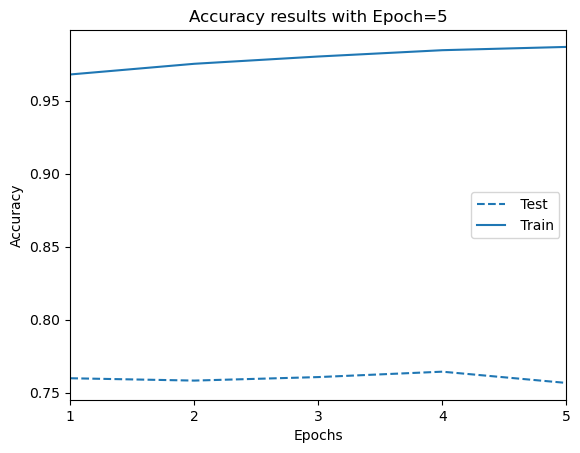

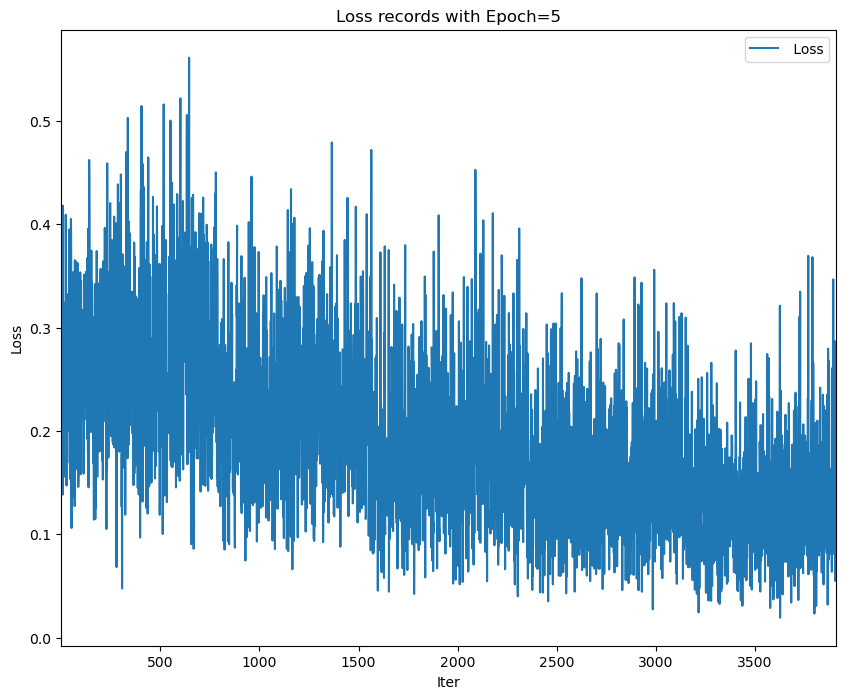

In [ ]:
history = {}
# Add config values to the history dictionary
for i in inspect.getmembers(config):
    # to remove private and protected
    # functions
    if not i[0].startswith('_'):
        # To remove other methods that
        # doesnot start with a underscore
        if not inspect.ismethod(i[1]):
            key, value = i
            config._dict[key] = value
history['config'] = config._dict
history['train_accs'] = train_accs
history['val_accs'] = val_accs
history['Num-Epochs'] = len(history['val_accs'])
plot_history(history)
plot_loss(losses)

# Save json and plot
with open(config._save_result_path+".json", 'w') as json_file:
    json.dump(history, json_file)
save_plot(config._save_result_path+".json")


In [ ]:
config._dict

{'SEED': 42,
 'batch_size': 128,
 'dataset': 'tiny-imagenet-200',
 'dropout_rate': 0.5,
 'epochs': 5,
 'image_res': 64,
 'l2_regularization_strength': 0,
 'lambda_contrastive': 10,
 'learning_rate': 1e-05,
 'model_name': 'vit_large_patch16_224',
 'num_classes': 200,
 'use_contrastive': False,
 'use_data_aug': True,
 'use_pretrained_model': True}